### Importing packages

In [1]:
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy import wcs
from photutils.aperture import RectangularAperture as RAp
from photutils.aperture import RectangularAnnulus as RAn
from photutils import aperture_photometry as apphot
from astropy.stats import sigma_clipped_stats

In [2]:
%matplotlib notebook
# %matplotlib widget

### Cosmological parameter

In [3]:
from astropy.cosmology import FlatLambdaCDM
redshift = 0.3527
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
ldist = cosmo.luminosity_distance(redshift).value    # Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value / 60.    # kpc/arcsec

### Loading Gemini GMOS/IFU FOV

In [4]:
# Gemini GMOS/IFU data cube
diG = "/data/jlee/DATA/Gemini/Programs/GN-2019A-Q-215/redux4_700/"
cubname = "cstxeqxbrgN20190611S0257_3D.fits"

# Reading necessary data
hdr = fits.getheader(diG+cubname, ext=0)
gra, gdec, gpa = hdr["RA"], hdr["DEC"], hdr["PA"]
print(gra, gdec, gpa)

268.0265 44.66745833 85.0


### Aperture photometry for HST images

In [5]:
# WCS XY conversion for HST images
diH = "/data/jlee/DATA/HLA/McPartland+16/MACS1752/JFG2/Phot/"
imglist = ["435_ori.fits", "606_ori.fits", "814_ori.fits", "110_ori.fits", "140_ori.fits"]
filt = ["F435W", "F606W", "F814W", "F110W", "F140W"]
Amag = [0.109, 0.075, 0.046, 0.027, 0.018]
fwhm = np.array([0.1, 0.1, 0.1, 0.2, 0.2])    # arcsec

h = fits.getheader(diH+imglist[1], ext=0)
w = wcs.WCS(h)
px, py = w.wcs_world2pix(gra, gdec, 1)
print(px, py)

197.83694006374435 180.0618772068807


In [6]:
# IFU FOV information
pixel_scale = 0.05    # arcsec/pixel
ifu_w, ifu_h = 7.0, 5.0    # arcsec

In [7]:
# Creating the FOV aperture
w0, h0 = ifu_w/pixel_scale, ifu_h/pixel_scale
ap = RAp((px-1, py-1), w=w0, h=h0, theta=gpa*np.pi/180.)
an = RAn((px-1, py-1), w_in=w0+10, w_out=w0+60,
         h_in=h0+10, h_out=h0+60, theta=gpa*np.pi/180.)

<IPython.core.display.Javascript object>


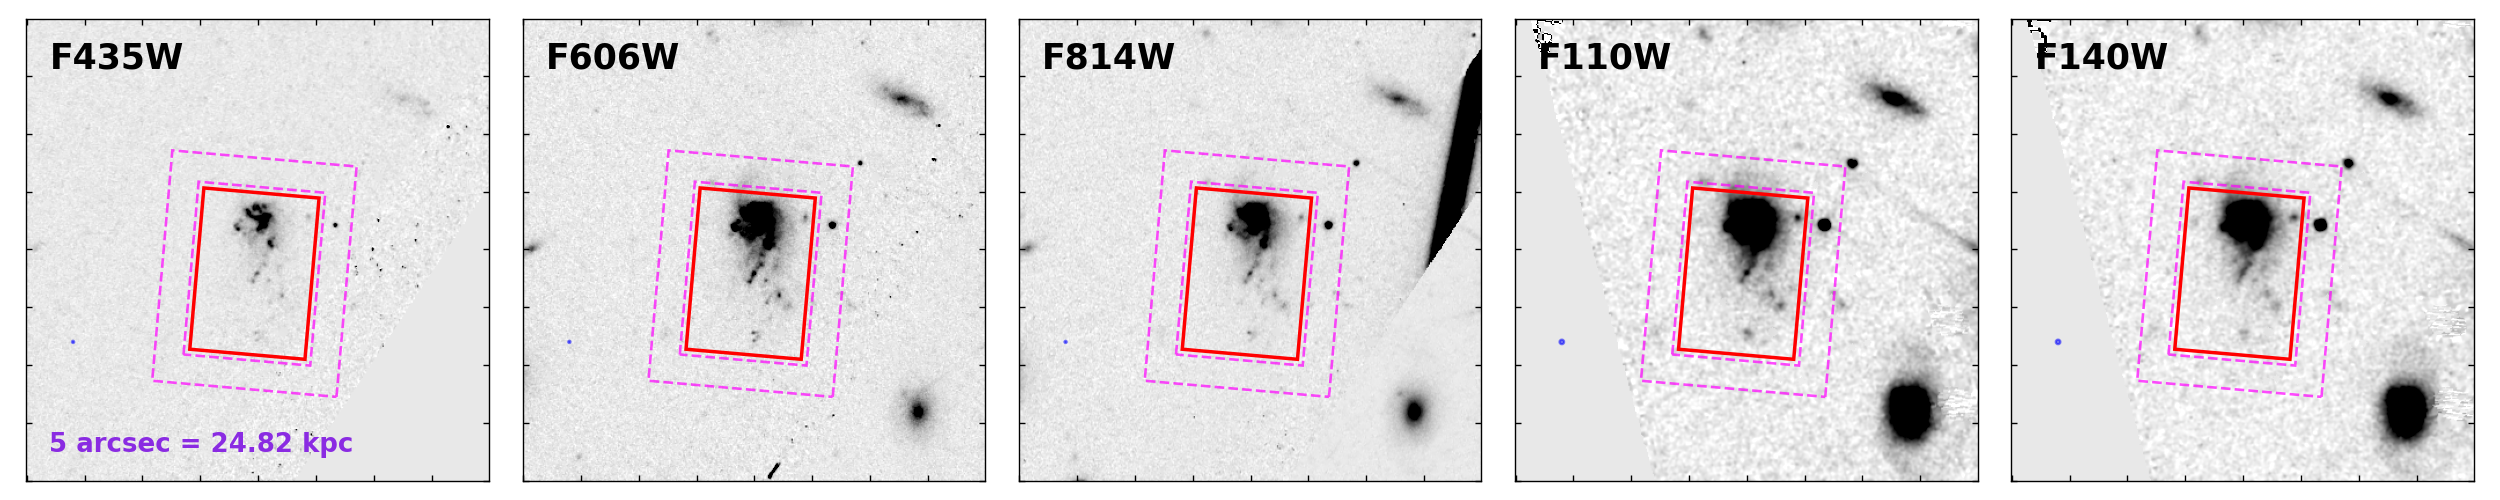

In [8]:
# Showing the FOV aperture
fig, ax = plt.subplots(1, len(imglist), figsize=(len(imglist)*4, 4))
for i in np.arange(len(imglist)):
    dat = fits.getdata(diH+imglist[i], ext=0, header=False)
    ax[i].imshow(dat, origin="lower", cmap="gray_r", vmin=-0.01, vmax=0.10)
    ax[i].tick_params(labelleft=False, labelbottom=False)
    ap_patches = ap.plot(axes=ax[i], color="red", lw=2.0, ls="-")
    an_patches = an.plot(axes=ax[i], color="magenta", lw=1.5, ls="--", alpha=0.7)
    c0 = plt.Circle((0.10*dat.shape[1], 0.30*dat.shape[0]),
                    radius=fwhm[i]/pixel_scale/2, color='blue', fill=True, ls='-', lw=1.25, alpha=0.5)
    ax[i].add_patch(c0)
    ax[i].text(0.05, 0.95, filt[i], fontsize=20.0, fontweight="bold", color="black",
               ha="left", va="top", transform=ax[i].transAxes)
    if (i == 0):
        ax[i].text(0.05, 0.05, f"5 arcsec = {5*kpc_per_arcsec:.2f} kpc", fontsize=15.0, fontweight="bold", color="blueviolet",
                   ha="left", va="bottom", transform=ax[i].transAxes)
plt.tight_layout()
plt.savefig("check_HST.png", dpi=300)

In [9]:
dat = fits.getdata(diH+imglist[0], ext=0, header=False)
dat.shape[0] * 0.05, 10.0 / 1.5

(20.0, 6.666666666666667)

In [10]:
# Aperture photometry for the IFU FOV
cols = [('id','U5'), ('x','<f4'), ('y','<f4'), 
        ('aperture_sum','<f4'), ('area_ap','<f4'),
        ('msky','<f8'), ('nsky','<f4'), ('sky_sigma','<f8'),
        ('source_sum','<f4'), ('mag','<f4'), ('merr','<f4')]
phot_table = np.zeros(len(imglist), dtype=cols)

for i in np.arange(len(imglist)):
    data, head = fits.getdata(diH+imglist[i], header=True, ext=0)
    zmag, gain, exptime, itime = head['MAGZERO'], head['CCDGAIN'], head['EXPTIME'], 1.0

    # Aperture photometry
    phot = apphot(data=data, apertures=ap)
    phot_table['id'][i] = filt[i]
    phot_table['x'][i], phot_table['y'][i] = phot['xcenter'].data[0], phot['ycenter'].data[0]
    phot_table['aperture_sum'][i] = phot['aperture_sum'].data[0]
    phot_table['area_ap'][i] = ap.area

    # Local sky estimation
    sky_mask = an.to_mask(method='center')
    sky_vals = sky_mask.multiply(data)
    skyv = sky_vals[sky_vals != 0.]
    nsky = np.sum(sky_vals != 0.)
    avg, med, std = sigma_clipped_stats(skyv, sigma=2.5, maxiters=10, std_ddof=1)
    if med - avg < 0.3 * std:
        msky = med
    else:
        msky = 2.5 * med - 1.5 * avg

    # Magitude calculation
    src_sum = phot['aperture_sum'].data[0] - ap.area*msky
    nflx = src_sum / itime
    tflx = nflx * exptime
    mag = zmag - 2.5*np.log10(nflx) - Amag[i]
    err = np.sqrt(tflx/gain + ap.area*std**2. + (ap.area**2. * std**2.)/nsky)

    phot_table['msky'][i], phot_table['nsky'][i], phot_table['sky_sigma'][i] = msky, nsky, std
    phot_table['source_sum'][i], phot_table['mag'][i], phot_table['merr'][i] = src_sum, mag, (2.5/np.log(10.0)) * (err/tflx)

In [11]:
phot_table

array([('F435W', 196.83694, 179.06187,  98.590996, 14000.,  0.0002134 , 15496., 0.00257582,  95.60345, 20.606356, 0.00156227),
       ('F606W', 196.83694, 179.06187, 354.2571  , 14000.,  0.00072442, 15496., 0.00375862, 344.11517, 20.08427 , 0.00067728),
       ('F814W', 196.83694, 179.06187, 252.39993 , 14000.,  0.00055272, 15496., 0.00286421, 244.66187, 19.92863 , 0.00061971),
       ('F110W', 196.83694, 179.06187, 607.31006 , 14000., -0.00043639, 15496., 0.00504253, 613.4195 , 19.82573 , 0.00104355),
       ('F140W', 196.83694, 179.06187, 459.17673 , 14000., -0.00128209, 15496., 0.00417162, 477.12604, 19.737734, 0.00118324)],
      dtype=[('id', '<U5'), ('x', '<f4'), ('y', '<f4'), ('aperture_sum', '<f4'), ('area_ap', '<f4'), ('msky', '<f8'), ('nsky', '<f4'), ('sky_sigma', '<f8'), ('source_sum', '<f4'), ('mag', '<f4'), ('merr', '<f4')])

In [12]:
m_AB_HST, e_m_AB_HST = phot_table['mag'], phot_table['merr']

### Aperture photometry for GALEX images

In [13]:
# WCS XY conversion for GALEX images
diG = "/data/jlee/DATA/HLA/McPartland+16/MACS1752/test_SED/MAST/GALEX/"
imglist_int = ["fd-int.fits", "nd-int.fits"]
imglist_bgr = ["fd-skybg.fits", "nd-skybg.fits"]
imglist_ext = ["fd-rrhr.fits", "nd-rrhr.fits"]
filt = ["FUV", "NUV"]
fwhm = np.array([4.2, 5.3])    # arcsec

h = fits.getheader(diG+imglist_int[0], ext=0)
w = wcs.WCS(h)
px, py = w.wcs_world2pix(gra, gdec, 1)
print(px, py)

3138.1476422690466 2543.3488901837172


In [14]:
# Creating the FOV aperture
pixel_scale = 1.5    # arcsec/pixel
w0, h0 = ifu_w/pixel_scale, ifu_h/pixel_scale
ap = RAp((px-1, py-1), w=w0*2.0, h=h0*2.0, theta=gpa*np.pi/180.)
# ap = RAp((px-1, py-1), w=np.maximum(fwhm.max()/pixel_scale, w0),
#          h=np.maximum(fwhm.max()/pixel_scale, h0), theta=gpa*np.pi/180.)
ap

<RectangularAperture([3137.14764227, 2542.34889018], w=9.333333333333334, h=6.666666666666667, theta=1.4835298641951802)>

<IPython.core.display.Javascript object>


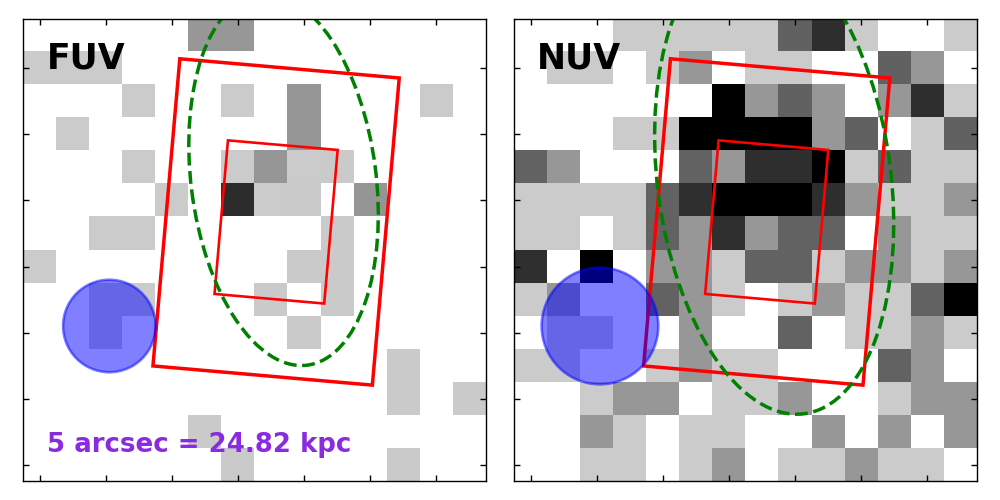

In [15]:
# Showing the FOV aperture
rth = 7    # for plotting
fig, ax = plt.subplots(1, len(imglist_int), figsize=(len(imglist_int)*4, 4))
for i in np.arange(len(imglist_int)):
    dat = fits.getdata(diG+imglist_int[i], ext=0, header=False)
    ax[i].imshow(dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth],
                 origin="lower", cmap="gray_r", vmin=0., vmax=0.02)
    ax[i].tick_params(labelleft=False, labelbottom=False)
    ap_plt0 = RAp((px-1-(int(px-1)-rth), py-1-(int(py-1)-rth)),
                 w=w0, h=h0,
#                  w=np.maximum(fwhm.max()/pixel_scale, w0),
#                  h=np.maximum(fwhm.max()/pixel_scale, h0),
                 theta=gpa*np.pi/180.)
    ap_patches = ap_plt0.plot(axes=ax[i], color="red", lw=1.5, ls="-")
    ap_plt = RAp((px-1-(int(px-1)-rth), py-1-(int(py-1)-rth)),
                 w=w0*2.0, h=h0*2.0,
#                  w=np.maximum(fwhm.max()/pixel_scale, w0),
#                  h=np.maximum(fwhm.max()/pixel_scale, h0),
                 theta=gpa*np.pi/180.)
    ap_patches = ap_plt.plot(axes=ax[i], color="red", lw=2.0, ls="-")
    from photutils.aperture import EllipticalAperture as EAp
    ax[i].text(0.05, 0.95, filt[i], fontsize=20.0, fontweight="bold", color="black",
               ha="left", va="top", transform=ax[i].transAxes)
    c0 = plt.Circle((0.15*dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth].shape[1],
                     0.30*dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth].shape[0]),
                    radius=fwhm[i]/pixel_scale/2, color='blue', fill=True, ls='-', lw=1.5, alpha=0.5)
    ax[i].add_patch(c0)
    if (i == 0):
        ax[i].text(0.05, 0.05, f"5 arcsec = {5*kpc_per_arcsec:.2f} kpc", fontsize=15.0, fontweight="bold", color="blueviolet",
                   ha="left", va="bottom", transform=ax[i].transAxes)
        ap2_plt = EAp((3137.3737-(int(px-1)-rth), 2543.6318-(int(py-1)-rth)), a=5.6628, b=2.8000, theta=-1.4441)
        ap_patches = ap2_plt.plot(axes=ax[i], color="green", lw=2.0, ls="--")
    else:
        ap2_plt = EAp((3137.3737-(int(px-1)-rth), 2543.6318-(int(py-1)-rth)), a=7.1459, b=3.5333, theta=-1.4441)
        ap_patches = ap2_plt.plot(axes=ax[i], color="green", lw=2.0, ls="--")        
plt.tight_layout()
plt.savefig("check_GALEX.png", dpi=300)

In [16]:
# Aperture photometry for the IFU FOV
cols = [('id','U5'), ('x','<f4'), ('y','<f4'), 
        ('aperture_sum','<f4'), ('area_ap','<f4'),
        ('msky','<f8'), ('nsky','<f4'), ('sky_sigma','<f8'),
        ('source_sum','<f4'), ('mag','<f4'), ('merr','<f4')]
phot_table = np.zeros(len(imglist_int), dtype=cols)

zeropoint = [18.82, 20.08]
E_bv = 0.03047207    # mag
cfac = [7.9, 8.0]    # Conversion factor (Gil de Paz+07)
Amag = np.array(cfac)*E_bv    # mag

for i in np.arange(len(imglist_int)):
    inten, hdr = fits.getdata(diG+imglist_int[i], header=True, ext=0)
    backgr = fits.getdata(diG+imglist_bgr[i], header=False, ext=0)
    eff_ext = fits.getdata(diG+imglist_ext[i], header=False, ext=0)

    mask_arr = np.zeros_like(inten).astype('bool')
    mask_arr[((inten == 0.) | (np.isnan(inten) == True))] = True

    # Aperture photometry
    phot = apphot(data=inten-backgr, apertures=ap,
                  error=np.sqrt(inten/eff_ext), mask=mask_arr)
    phot_table['id'][i] = filt[i]
    phot_table['x'][i], phot_table['y'][i] = phot['xcenter'].data[0], phot['ycenter'].data[0]
    phot_table['aperture_sum'][i] = phot['aperture_sum'].data[0]
    phot_table['source_sum'][i] = phot_table['aperture_sum'][i]
    phot_table['area_ap'][i] = ap.area

    mag = zeropoint[i] - 2.5*np.log10(phot['aperture_sum'].data[0]) - Amag[i]
    merr = (2.5/np.log(10.0)) * (phot['aperture_sum_err'].data[0]/phot['aperture_sum'].data[0])

    # Local sky estimation
    sky_mask = ap.to_mask(method='center')
    sky_vals = sky_mask.multiply(backgr)
    skyv = sky_vals[sky_vals != 0.]
    nsky = np.sum(sky_vals != 0.)
    avg, med, std = sigma_clipped_stats(skyv, sigma=2.5, maxiters=10, std_ddof=1)
    if med - avg < 0.3 * std:
        msky = med
    else:
        msky = 2.5 * med - 1.5 * avg

    phot_table['msky'][i], phot_table['nsky'][i], phot_table['sky_sigma'][i] = msky, nsky, std
    phot_table['mag'][i], phot_table['merr'][i] = mag, merr

In [17]:
phot_table

array([('FUV', 3137.1477, 2542.3489, 0.09383677, 62.22222, 0.00046259, 64., 2.20713224e-07, 0.09383677, 21.148338, 0.23774792),
       ('NUV', 3137.1477, 2542.3489, 0.43537295, 62.22222, 0.00297885, 64., 8.04842718e-07, 0.43537295, 20.739069, 0.12155162)],
      dtype=[('id', '<U5'), ('x', '<f4'), ('y', '<f4'), ('aperture_sum', '<f4'), ('area_ap', '<f4'), ('msky', '<f8'), ('nsky', '<f4'), ('sky_sigma', '<f8'), ('source_sum', '<f4'), ('mag', '<f4'), ('merr', '<f4')])

In [18]:
m_AB_GALEX, e_m_AB_GALEX = phot_table['mag'], phot_table['merr']

### Aperture photometry for Spitzer images

In [19]:
# WCS XY conversion for Spitzer images
diS = "/data/jlee/DATA/Spitzer/IRAC/MACS1752/r58320128/"
imglist_maic = sorted(glob.glob(diS+"*/pbcd/*_maic.fits"))
imglist_munc = sorted(glob.glob(diS+"*/pbcd/*_munc.fits"))
filt = ["IRAC1 (3.6)", "IRAC2 (4.5)"]
fwhm = np.array([1.95, 2.02])    # arcsec

h = fits.getheader(imglist_maic[0], ext=0)
w = wcs.WCS(h)
px, py = w.wcs_world2pix(gra, gdec, 1)
print(px, py)

1217.3133999973475 499.8611411604372


In [20]:
# Creating the FOV aperture
pixel_scale = 0.6    # arcsec/pixel
w0, h0 = ifu_w/pixel_scale, ifu_h/pixel_scale
ap = RAp((px-1, py-1), w=w0, h=h0, theta=(gpa-287.81478)*np.pi/180.)
an = RAn((px-1, py-1), w_in=w0+2, w_out=w0+8,
         h_in=h0+2, h_out=h0+8, theta=gpa*np.pi/180.)

<IPython.core.display.Javascript object>


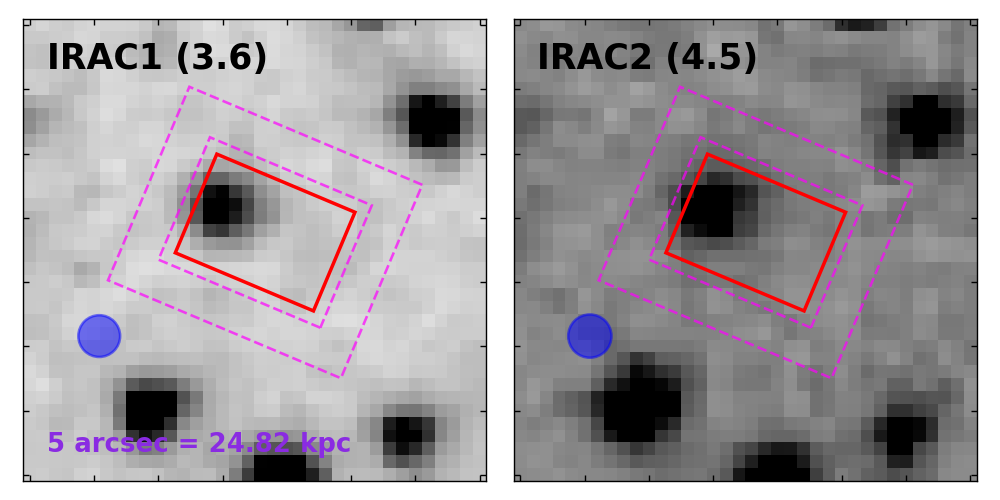

In [21]:
# Showing the FOV aperture
rth = 18    # for plotting
fig, ax = plt.subplots(1, len(imglist_maic), figsize=(len(imglist_maic)*4, 4))
for i in np.arange(len(imglist_maic)):
    dat = fits.getdata(imglist_maic[i], ext=0, header=False)
    ax[i].imshow(dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth],
                 origin="lower", cmap="gray_r", vmin=0., vmax=0.15)
    ax[i].tick_params(labelleft=False, labelbottom=False)
    ap_plt = RAp((px-1-(int(px-1)-rth), py-1-(int(py-1)-rth)),
                 w=w0, h=h0, theta=(gpa-287.81478)*np.pi/180.)
    ap_patches = ap_plt.plot(axes=ax[i], color="red", lw=2.0, ls="-")
    an_plt = RAn((px-1-(int(px-1)-rth), py-1-(int(py-1)-rth)),
                 w_in=w0+2, w_out=w0+8, h_in=h0+2, h_out=h0+8,
                 theta=(gpa-287.81478)*np.pi/180.)
    an_patches = an_plt.plot(axes=ax[i], color="magenta", lw=1.5, ls="--", alpha=0.7)
    ax[i].text(0.05, 0.95, filt[i], fontsize=20.0, fontweight="bold", color="black",
               ha="left", va="top", transform=ax[i].transAxes)
    c0 = plt.Circle((0.15*dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth].shape[1],
                     0.30*dat[int(py-1)-rth:int(py-1)+rth, int(px-1)-rth:int(px-1)+rth].shape[0]),
                    radius=fwhm[i]/pixel_scale/2, color='blue', fill=True, ls='-', lw=1.5, alpha=0.5)
    ax[i].add_patch(c0)
    if (i == 0):
        ax[i].text(0.05, 0.05, f"5 arcsec = {5*kpc_per_arcsec:.2f} kpc", fontsize=15.0, fontweight="bold", color="blueviolet",
                   ha="left", va="bottom", transform=ax[i].transAxes)
plt.tight_layout()
plt.savefig("check_Spitzer.png", dpi=300)

In [22]:
# Aperture photometry for the IFU FOV
cols = [('id','U5'), ('x','<f4'), ('y','<f4'), 
        ('aperture_sum','<f4'), ('area_ap','<f4'),
        ('msky','<f8'), ('nsky','<f4'), ('sky_sigma','<f8'),
        ('source_sum','<f4'), ('mag','<f4'), ('merr','<f4')]
phot_table = np.zeros(len(imglist_int), dtype=cols)

zeropoint = [18.80, 18.32]
flux0 = [280.9, 179.7]    # Jy
m0_AB = 23.93    # microJy

for i in np.arange(len(imglist_maic)):
    dat, hdr = fits.getdata(imglist_maic[i], header=True, ext=0)
    unc = fits.getdata(imglist_munc[i], header=False, ext=0)

    # Aperture photometry
    phot = apphot(data=dat, apertures=ap, error=unc)
    phot_table['id'][i] = filt[i]
    phot_table['x'][i], phot_table['y'][i] = phot['xcenter'].data[0], phot['ycenter'].data[0]
    phot_table['aperture_sum'][i] = phot['aperture_sum'].data[0]
    phot_table['area_ap'][i] = ap.area

    # Local sky estimation
    sky_mask = an.to_mask(method='center')
    sky_vals = sky_mask.multiply(dat)
    skyv = sky_vals[sky_vals != 0.]
    nsky = np.sum(sky_vals != 0.)
    avg, med, std = sigma_clipped_stats(skyv, sigma=2.5, maxiters=10, std_ddof=1)
    if med - avg < 0.3 * std:
        msky = med
    else:
        msky = 2.5 * med - 1.5 * avg

    # Magitude calculation
    src_sum = phot['aperture_sum'].data[0] - ap.area*msky
    mag = zeropoint[i] - 2.5*np.log10(src_sum) + (m0_AB - 2.5*np.log10(flux0[i]*1.0e+6))
    err = np.sqrt(phot['aperture_sum_err'].data[0]**2. + ap.area*std**2. + (ap.area**2. * std**2.)/nsky)
    merr = (2.5/np.log(10.0)) * (err/src_sum)

    phot_table['msky'][i], phot_table['nsky'][i], phot_table['sky_sigma'][i] = msky, nsky, std
    phot_table['source_sum'][i], phot_table['mag'][i], phot_table['merr'][i] = src_sum, mag, merr

In [23]:
phot_table

array([('IRAC1', 1216.3134, 498.86115, 5.583723, 97.22222, 0.03089825, 181., 0.00441376, 2.5797262, 20.579687, 0.0417022 ),
       ('IRAC2', 1216.3134, 498.86115, 9.738323, 97.22222, 0.07177848, 181., 0.00530591, 2.7598598, 20.511412, 0.03740961)],
      dtype=[('id', '<U5'), ('x', '<f4'), ('y', '<f4'), ('aperture_sum', '<f4'), ('area_ap', '<f4'), ('msky', '<f8'), ('nsky', '<f4'), ('sky_sigma', '<f8'), ('source_sum', '<f4'), ('mag', '<f4'), ('merr', '<f4')])

In [24]:
m_AB_Spitzer, e_m_AB_Spitzer = phot_table['mag'], phot_table['merr']

### Stacking the results & Comparing photometry

In [25]:
m_AB = np.hstack((m_AB_GALEX, m_AB_HST, m_AB_Spitzer))

In [26]:
e_m_AB = np.hstack((e_m_AB_GALEX, e_m_AB_HST, e_m_AB_Spitzer))

In [27]:
m_AB, e_m_AB

(array([21.148338, 20.739069, 20.606356, 20.08427 , 19.92863 , 19.82573 ,
        19.737734, 20.579687, 20.511412], dtype=float32),
 array([0.23774792, 0.12155162, 0.00156227, 0.00067728, 0.00061971,
        0.00104355, 0.00118324, 0.0417022 , 0.03740961], dtype=float32))

In [28]:
# Old photometry
m_AB_0 = np.array([21.085, 20.626, 20.796, 20.2101, 20.0366, 19.9487, 19.8797, 20.593, 20.463])
e_m_AB_0 = np.array([0.23, 0.118, 0.1, 0.1, 0.1, 0.1, 0.1, 0.246, 0.197])

In [29]:
m_AB - m_AB_0

array([ 0.06333832,  0.11306898, -0.18964433, -0.12582952, -0.10796917,
       -0.12297063, -0.14196616, -0.01331288,  0.04841167])